## Get Data

In [1]:
import pandas as pd

# read in data file
data = pd.read_csv('data/Anime.csv')
data.rename(str.strip, axis='columns', inplace=True)

# create target dataframe
synopsis_df = data[['synopsis', 'score', 'members']]
del data

#### Identify and remove nulls

In [2]:
# identify nulls
print(synopsis_df['synopsis'].isnull().value_counts())
print(synopsis_df['score'].isnull().value_counts())
print(synopsis_df['members'].isnull().value_counts())


False    14565
True       713
Name: synopsis, dtype: int64
False    14778
True       500
Name: score, dtype: int64
False    15273
True         5
Name: members, dtype: int64


In [3]:
# remove nulls
synopsis_df = synopsis_df.dropna(axis=0, how='any')

# check for removal
print(synopsis_df['synopsis'].isnull().value_counts())
print(synopsis_df['score'].isnull().value_counts())
print(synopsis_df['members'].isnull().value_counts())


False    14199
Name: synopsis, dtype: int64
False    14199
Name: score, dtype: int64
False    14199
Name: members, dtype: int64


#### Create some test synopses

we can use these if we need to quickly reference a cleaned synopsis for prediction testing

In [4]:
bebop = synopsis_df['synopsis'][0]
witches = synopsis_df['synopsis'][3]
print(bebop)
print(witches)

In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and 

#### Clean Text

We wrote a quick text cleaning module, let's import and apply

In [5]:
from clean_text import clean_text

# clean all synopses
synopsis_df['synopsis'] = synopsis_df['synopsis'].apply(lambda x: clean_text(x))

## Data Exploration

Let's investigate the data a bit.

For starters, the length of our synopses.

In [6]:
# investigate synopsis length
synopsis_df['synopsis'].apply(lambda x: len(x)).describe()

count    14199.000000
mean       360.472075
std        317.977344
min          8.000000
25%         98.000000
50%        272.000000
75%        535.000000
max       3140.000000
Name: synopsis, dtype: float64

In [7]:
# number of synopses > 1000 characters
len(synopsis_df[synopsis_df['synopsis'].apply(lambda x: len(x)) > 1000])

669

Let's take a peek at the distributions of our potential target variables: score and members

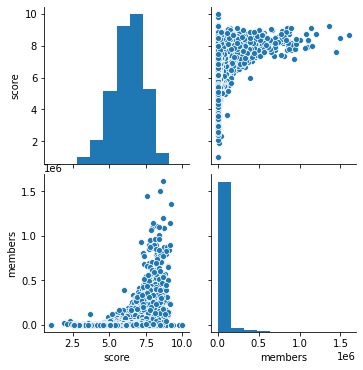

In [8]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.pairplot(synopsis_df)

Total members and score is pretty strongly correlated as would be expected.

Score looks relatively normal which is good, but it looks like our members data is pretty skewed -- let's log scale it.

(array([ 118., 1405., 2690., 2148., 2455., 2031., 1603., 1122.,  527.,
         100.]),
 array([ 2.39789527,  3.58731506,  4.77673484,  5.96615463,  7.15557441,
         8.3449942 ,  9.53441398, 10.72383377, 11.91325355, 13.10267334,
        14.29209312]),
 <a list of 10 Patch objects>)

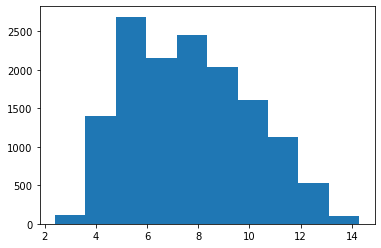

In [9]:
import numpy as np 

log_members = synopsis_df['members'].apply(lambda x: np.log(x))

plt.hist(log_members)

Alright, this looks a bit friendlier. 

In [10]:
# save the log transformed version
synopsis_df['log_members'] = log_members

In [11]:
# # tokenize text
# synopsis_df['synopsis'] = synopsis_df['synopsis'].apply(lambda x: word_tokenize(x))
# synopsis_df['synopsis']

## Train/Test/Val Split

In [12]:
from sklearn.model_selection import train_test_split

X, y = synopsis_df['synopsis'], synopsis_df['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=77)

## Modelling


#### Testing vectorizers, n_gram and LSA topic numbers

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

In [61]:
ngrams_list = [(1,1), (1,2), (2,2)]
max_topics = 30

topic_doc_matrices = []
fit_transformers = []
r_squared_scores = []

temp_train = X_train.copy()

count = 0

for ngram_idx, gram in enumerate(ngrams_list):
    # temp_val = X_val.copy()
    vectorizers = [CountVectorizer(stop_words='english', ngram_range=gram), TfidfVectorizer(stop_words='english', ngram_range=gram)]
    
    for vec_idx, vectorizer in enumerate(vectorizers):
        vectorizer.fit(temp_train)
        temp_train_vectorized = vectorizer.transform(temp_train)
        # temp_val = vectorizer.transform(...val)
        
        for n_topics in range(3, max_topics):
            lsa_methods = [TruncatedSVD(n_topics), NMF(n_topics)]
            
            for lsa_idx, lsa in enumerate(lsa_methods):
                # print(ngram_idx, vec_idx, lsa_idx)
                # print(temp_train[0])

                lsa.fit(temp_train_vectorized)
                doc_topic_matrix = lsa.transform(temp_train_vectorized)
                # temp_val = lsa.transform(...val)
                
                doc_topic_df = pd.DataFrame(doc_topic_matrix, index=y_train)
                doc_topic_df = doc_topic_df.reset_index() 
                doc_topic_df.drop(columns='score', inplace=True)

                lr = LinearRegression()
                lr.fit(doc_topic_df, y_train)
                
                r_squared_scores.append(lr.score(doc_topic_df, y_train))
                topic_doc_matrices.append(doc_topic_matrix)
                fit_transformers.append((vectorizer, lsa))

                #reset it
                count += 1
                if count%10 == 0:
                    print(r_squared_scores[count-10:count])


                # store the vectorized, form, and the configuration
                # (ngrams, vectorizer, lsa, n_topics)

# iterate through the vectorized dfs, fit a regression, store the r^2 and rank

AttributeError: 'list' object has no attribute 'lower'

In [35]:
potential_idx = list(np.where(np.array(r_squared_scores) > .18)[0])

In [41]:
[r_squared_scores[i] for i in potential_idx]

[0.18110450952189605,
 0.18020852178695312,
 0.1869816179829089,
 0.18323933256122438,
 0.1851922276141914,
 0.189584484765849,
 0.18086140482858204,
 0.18748005081331653,
 0.18912341759515683,
 0.18871686920271247,
 0.19110736283618757,
 0.18766930040173746,
 0.1809745504348964,
 0.18674093109400836,
 0.19313509498433468,
 0.19652075273504654,
 0.19507745575304858,
 0.19407565538138938,
 0.19449365757706627,
 0.19822361783445208,
 0.18032823079906368,
 0.18329899670287042,
 0.18310426513456612,
 0.18191944433240692,
 0.18008283477038844,
 0.18001797116306484,
 0.1864881579406259,
 0.18021678294221277,
 0.18419732315820714,
 0.18114070210138666,
 0.18010074934164355,
 0.18414042854582202,
 0.18585271112881374,
 0.18479535927693913,
 0.18591990025690797,
 0.19112396985316638,
 0.18600172485590794,
 0.19255924356786092,
 0.18594589266019101,
 0.19186620276855304,
 0.18584924169195416,
 0.19391927636281325,
 0.1855729056942036,
 0.19720472600477013,
 0.18540395166737023,
 0.19486430051589

In [36]:
potential_topic_docs = [topic_doc_matrices[i] for i in potential_idx]
potential_fit_transformers = [fit_transformers[i] for i in potential_idx]

In [40]:
for i in range(len(potential_fit_transformers)):
    print(potential_fit_transformers[i])

(CountVectorizer(stop_words='english'), TruncatedSVD(n_components=24))
(CountVectorizer(stop_words='english'), TruncatedSVD(n_components=25))
(CountVectorizer(stop_words='english'), TruncatedSVD(n_components=26))
(CountVectorizer(stop_words='english'), TruncatedSVD(n_components=27))
(CountVectorizer(stop_words='english'), TruncatedSVD(n_components=28))
(CountVectorizer(stop_words='english'), TruncatedSVD(n_components=29))
(TfidfVectorizer(stop_words='english'), TruncatedSVD(n_components=17))
(TfidfVectorizer(stop_words='english'), TruncatedSVD(n_components=18))
(TfidfVectorizer(stop_words='english'), TruncatedSVD(n_components=19))
(TfidfVectorizer(stop_words='english'), TruncatedSVD(n_components=20))
(TfidfVectorizer(stop_words='english'), TruncatedSVD(n_components=21))
(TfidfVectorizer(stop_words='english'), TruncatedSVD(n_components=22))
(TfidfVectorizer(stop_words='english'), NMF(n_components=22))
(TfidfVectorizer(stop_words='english'), TruncatedSVD(n_components=23))
(TfidfVectorize

Looks like most of our top results come from TF-IDF vectorization, with 1-2 ngrams and at least 20ish components

TruncatedSVD looks substantially more represented in the unigram case, while NMF is about equally present when including bigrams. 

Since bigrams are more present overall in our best performing models, let's use **TF-IDF**, **bigrams** and **NMF** since it should be slightly faster than TrSVD. We'll test between 15 and 30 NMF components on our validation set to see what ends up looking best.


### Vectorize and Factorize Training Data

In [15]:
# fit vectorizer to training data
tf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
tf_vec.fit(X_train)

# transform for factorizer
X_train_vecs = tf_vec.transform(X_train)
X_val_vecs = tf_vec.transform(X_val)

In [16]:
# fit factorizer to training data
nmf_fac = NMF(15)
nmf_fac.fit(X_train_vecs)

# transform for predictor
X_train_topic_doc = nmf_fac.transform(X_train_vecs)
X_val_topic_doc = nmf_fac.transform(X_val_vecs)

### Fit regression models

In [17]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train_topic_doc, y_train)

LinearRegression()

In [72]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=77)
rfr.fit(X_train_topic_doc, y_train)

RandomForestRegressor(random_state=77)

In [71]:
from xgboost import XGBRegressor
xgbr = XGBRegressor(random_state=77)
xgbr.fit(X_train_topic_doc, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=77,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(random_state=77)
ada.fit(X_train_topic_doc, y_train)

AdaBoostRegressor(random_state=77)

### Store regression models

In [59]:
import pickle as pkl

# store the transformers
with open('transformers/tfidf.pkl', 'wb') as f:
    pkl.dump(tf_vec, f)
with open('transformers/nmf.pkl', 'wb') as f:
    pkl.dump(nmf_fac, f)
    
# store the regression models
with open('./models/linreg.pkl', 'wb') as f:
    pkl.dump(linreg, f)
with open('./models/rfreg.pkl', 'wb') as f:
    pkl.dump(rfr, f)
with open('./models/xgbreg.pkl', 'wb') as f:
    pkl.dump(xgbr, f)
with open('./models/adabreg.pkl', 'wb') as f:
    pkl.dump(ada, f)

### Baseline model scores

Ways to tune model:
* test diff num categories (15-30) on validation set
* add regularization and cross-validate
* use other regression methods


In [21]:
from sklearn.metrics import r2_score

In [54]:
print(f'LR Train R^2: {r2_score(y_train, linreg.predict(X_train_topic_doc))}')
print(f'LR Val R^2: {r2_score(y_val, linreg.predict(X_val_topic_doc))}')


LR Train R^2: 0.17998854520276186
LR Val R^2: 0.11541544337977683


In [50]:
print(f'RF Train R^2: {r2_score(y_train, rfr.predict(X_train_topic_doc))}')
print(f'RF Val R^2: {r2_score(y_val, rfr.predict(X_val_topic_doc))}')

RF Train R^2: 0.3572332197539413
RF Val R^2: 0.1262140680997892


In [51]:
print(f'XGB Train R^2: {r2_score(y_train, xgbr.predict(X_train_topic_doc))}')
print(f'XGB Val R^2: {r2_score(y_val, xgbr.predict(X_val_topic_doc))}')

XGB Train R^2: 0.6035637344490588
XGB Val R^2: 0.13156891498718393


In [56]:
print(f'AdaB Val R^2: {r2_score(y_train, ada.predict(X_train_topic_doc))}')
print(f'AdaB Val R^2: {r2_score(y_val, ada.predict(X_val_topic_doc))}')


AdaB Val R^2: 0.11849346862123011
AdaB Val R^2: 0.13168095016456016


### Model Tuning

First we'll look at how changing the number of LSA topics affects our predictions

In [36]:
# test diff num categories 
nmf_scores = []
for num_topics in range(14, 30):
    train_data = X_train_vecs.copy()
    val_data = X_val_vecs.copy()
    nmf = NMF(num_topics)
    nmf.fit(train_data)
    train_data = nmf.transform(train_data)
    val_data = nmf.transform(val_data)
    lr = LinearRegression()
    lr.fit(train_data, y_train)
    nmf_scores.append((num_topics, lr.score(train_data, y_train), lr.score(val_data, y_val)))

nmf_scores



[(14, 0.18008284782700956, 0.11241027290874428),
 (15, 0.18648905876213218, 0.12149551173385176),
 (16, 0.18420072564962642, 0.11811150876335852),
 (17, 0.18010137208182886, 0.11184987331009055),
 (18, 0.18458400046038048, 0.11821565323112804),
 (19, 0.18032516093766626, 0.11273472081571889),
 (20, 0.1811026083941656, 0.11452749734155143),
 (21, 0.181133528260515, 0.11457703907765404),
 (22, 0.18584870455694213, 0.12204099347603736),
 (23, 0.18106541552665478, 0.11508843932554547),
 (24, 0.18540341370843572, 0.12146709885007334),
 (25, 0.18502761295575954, 0.12172714417953989),
 (26, 0.18529590482619585, 0.12184313653704704),
 (27, 0.1795334181203122, 0.12503439408599093),
 (28, 0.17985933576120183, 0.12499884314582532),
 (29, 0.1798471859434161, 0.1221980417716777)]

### Text Scoring
We developed a small module, score_text, for predicting scores using the pre-fitted vectorizer, factorizer and regression models.

It takes a piece of text and applies our text cleaner, vectorizes and factorizes with the specified pre-fit transformers, then scores the text using the specified pre-trained regression model.

In [22]:
from score_text import score

vec = tf_vec #pre-fit vectorizer
fac = nmf_fac #pre-fit factorizer
pred = linreg #pre-trained regressor

score(witches, vec, fac, pred)


6.39

Let's make a function that will let us quickly generate scores for each of our models

In [23]:
# score a synopsis for each of the given models
def compare_model_scores(text, models, transformers, model_names=None):
    vec = transformers['vectorizer']
    fac = transformers['factorizer']
    model_scores = []
    for idx, model in enumerate(models):
        model_score = score(text, vec, fac, model)
        model_scores.append(model_score.round(2))
        if model_names:
            print(f'{model_names[idx]}: {score(text, vec, fac, model)}')
    if model_names == None:
        return model_scores 

In [24]:
baseline_models = [linreg, rfr, xgbr, ada] 
baseline_model_names = ['lr', 'rfr', 'xgbr', 'ada']
baseline_transformers = {'vectorizer':tf_vec,
                'factorizer':nmf_fac}

print(compare_model_scores(bebop, baseline_models, baseline_transformers, baseline_model_names))
print(compare_model_scores(bebop, baseline_models, baseline_transformers))

lr: 6.62
rfr: 8.15
xgbr: 6.980000019073486
ada: 6.12
None
[6.62, 8.15, 6.98, 6.12]


Let's generate a collection of doc topic matrices w/ different n_topics (14-30) so we can try our models on each of them 

In [29]:
# list of x-train nmf'd w/ diff values
# should probably make this a generator but im lazy
def generate_doc_topic_matrix_dict(train_vecs, test_vecs, min_topics, max_topics, factorizer):
    matrix_dict = {}
    for n_topics in range(min_topics, max_topics+1):
        # reset text data
        train_data = train_vecs.copy()
        test_data = test_vecs.copy()

        # fit n_topics factorizer to training data
        current_fac = factorizer(n_topics)
        current_fac.fit(train_data)

        #transform train and test data
        train_data = current_fac.transform(train_data)
        test_data = current_fac.transform(test_data)
        
        matrix_dict[n_topics] = [train_data, test_data]

    return matrix_dict


In [31]:
nmf_dict = generate_doc_topic_matrix_dict(X_train_vecs, X_val_vecs, 3, 30, NMF)

In [37]:
# store the dict since it takes a while to make
with open('data/nmf_dict.pkl', 'wb') as f:
    pkl.dump(nmf_dict, f)

In [54]:
# take an nmf matrix
# fit all the regression models 
# store the training and val r^2 for each one
def compare_n_topic_by_model(doc_topic_dict, models, model_names):
    """
    take a dictionary of doc topic matrices w/ n_topics as key, fit and score models, return df of scores
    """
    df = pd.DataFrame(columns=['n_topics', 'model', 'train_r2', 'val_r2'])
    for n_topics in doc_topic_dict.keys():
        train = doc_topic_dict[n_topics][0]
        test = doc_topic_dict[n_topics][1]
        for idx, model in enumerate(models):
            model.fit(train, y_train)
            train_r2 = r2_score(y_train, model.predict(train))
            test_r2 = r2_score(y_val, model.predict(test))
            row = {'n_topics': n_topics,
                   'model': model_names[idx],
                   'train_r2': train_r2,
                   'val_r2': test_r2}
            df = df.append(row, ignore_index=True)
    return df
    # n_topics, model name, train, validation    


# see what n_topics each model performs best at

In [57]:
baseline_nmf_scores = compare_n_topic_by_model(nmf_dict, baseline_models, baseline_model_names)
baseline_nmf_scores

,n_topics,model,train_r2,val_r2
0,3,lr,0.082338,0.065327
1,3,rfr,0.840315,-0.115552
2,3,xgbr,0.426797,0.046186
3,3,ada,0.036370,0.052455
4,4,lr,0.128600,0.057559
...,...,...,...,...
107,29,ada,0.048605,0.069134
108,30,lr,0.180350,0.129045
109,30,rfr,0.888874,0.215665
110,30,xgbr,0.676863,0.125025


In [59]:
baseline_nmf_scores.groupby('model').mean()

,train_r2,val_r2
model,,
ada,0.088432,0.095756
lr,0.173157,0.109781
rfr,0.878087,0.140374
xgbr,0.598499,0.106270


Looks like the ensembled models are capable of vastly overfitting to the training data, but still eke out comparable performance on the validation sets to regular regression or xgboost.

Still, this mean isn't a great representation of performance since the information being modeled is so different across the different n_topics in factorization. Let's take a look at the individual models.

In [68]:
"""
LINEAR REGRESSION
"""
baseline_nmf_scores[baseline_nmf_scores['model'] == 'lr'].sort_values('val_r2', ascending=False).head(10)

,n_topics,model,train_r2,val_r2
108,30,lr,0.180350,0.129045
92,26,lr,0.187654,0.127154
96,27,lr,0.188361,0.126119
100,28,lr,0.178024,0.123664
104,29,lr,0.180675,0.123108
72,21,lr,0.185936,0.122272
80,23,lr,0.185572,0.122212
76,22,lr,0.185849,0.122043
88,25,lr,0.185670,0.121542
48,15,lr,0.186489,0.121496


In [66]:
"""
RANDOM FOREST REGRESSION
"""
baseline_nmf_scores[baseline_nmf_scores['model'] == 'rfr'].sort_values('val_r2', ascending=False).head(10)

,n_topics,model,train_r2,val_r2
109,30,rfr,0.888874,0.215665
101,28,rfr,0.886225,0.208582
105,29,rfr,0.887463,0.204537
97,27,rfr,0.887427,0.199721
93,26,rfr,0.885664,0.195348
89,25,rfr,0.885849,0.188355
81,23,rfr,0.885057,0.185184
85,24,rfr,0.886416,0.181309
49,15,rfr,0.882166,0.179317
73,21,rfr,0.884882,0.172829


In [67]:
"""
XGBOOST REGRESSION
"""
baseline_nmf_scores[baseline_nmf_scores['model'] == 'xgbr'].sort_values('val_r2', ascending=False).head(10)

,n_topics,model,train_r2,val_r2
58,17,xgbr,0.616493,0.134043
98,27,xgbr,0.664657,0.126659
110,30,xgbr,0.676863,0.125025
50,15,xgbr,0.614933,0.124482
54,16,xgbr,0.611100,0.124363
62,18,xgbr,0.610372,0.123547
74,21,xgbr,0.655823,0.121297
94,26,xgbr,0.661772,0.119568
30,10,xgbr,0.583276,0.117686
106,29,xgbr,0.655318,0.116543


In [69]:
"""
ADABOOST REGRESSION
"""
baseline_nmf_scores[baseline_nmf_scores['model'] == 'ada'].sort_values('val_r2', ascending=False).head(10)

,n_topics,model,train_r2,val_r2
51,15,ada,0.147519,0.157503
19,7,ada,0.164413,0.153350
27,9,ada,0.150919,0.145645
39,12,ada,0.131936,0.137347
43,13,ada,0.130121,0.129543
23,8,ada,0.137928,0.127340
35,11,ada,0.133250,0.124527
47,14,ada,0.089358,0.120502
31,10,ada,0.097910,0.117849
67,19,ada,0.113901,0.114133


*NOTE: Added random_state=77 to regression models on Monday, 9/7. Above data was generated without random_state being set, so reproduction will likely produce different results from those shown until re-run.* 

Random Forest clearly takes the cake here, despite what looks like clear overfitting on the training data (.88 r^2 is well beyond reasonable), it seems to be picking up on enough to perform 5%+ better on validation than our other candidates. Let's move forward with optimizations using the Random Forest Regressor as our model of choice. 

There seems to be a relatively consistent improvement in r^2 as we increase our n_topics. Since our highest training and validation score came from our largest number of topics, let's see how much more we can squeak out by testing some larger n_topics at it. We don't really care about topic interpretability, and the factorization converges relatively quickly so we can keep pushing it without much worry.

In [74]:
nmf_dict_30_50 = generate_doc_topic_matrix_dict(X_train_vecs, X_val_vecs, 30, 50, NMF)
nmf_scores_30_50 = compare_n_topic_by_model(nmf_dict_30_50, [rfr], ['rfr'])
nmf_scores_30_50.sort_values('val_r2', ascending=False).head(10)


,n_topics,model,train_r2,val_r2
18,48,rfr,0.891541,0.247341
17,47,rfr,0.891159,0.246655
19,49,rfr,0.890108,0.246074
13,43,rfr,0.891307,0.244123
12,42,rfr,0.889027,0.242252
15,45,rfr,0.890324,0.241998
20,50,rfr,0.891652,0.241975
14,44,rfr,0.890469,0.240585
16,46,rfr,0.891080,0.239164
10,40,rfr,0.888526,0.236544


Wow, +.03 validation r^2 from going up to around 50. Seems like we're starting to see a drop off in gain consistency as we increase n_topics, but let's try a little bit more. 

In [75]:
nmf_dict_50_70 = generate_doc_topic_matrix_dict(X_train_vecs, X_val_vecs, 50, 70, NMF)
nmf_scores_50_70 = compare_n_topic_by_model(nmf_dict_50_70, [rfr], ['rfr'])
nmf_scores_50_70.sort_values('val_r2', ascending=False).head(10)

,n_topics,model,train_r2,val_r2
14,64,rfr,0.890879,0.262143
19,69,rfr,0.892038,0.256849
17,67,rfr,0.890308,0.255456
5,55,rfr,0.891294,0.254965
13,63,rfr,0.891281,0.253373
16,66,rfr,0.891685,0.253011
4,54,rfr,0.892134,0.252623
12,62,rfr,0.891164,0.251743
9,59,rfr,0.891326,0.251377
11,61,rfr,0.891057,0.251172


In [79]:
# that took forever so let's save those in case we want to go back later
with open('data/nmf_dict_30_50.pkl', 'wb') as f:
    pkl.dump(nmf_dict_30_50, f)

with open('data/nmf_dict_50_70.pkl', 'wb') as f:
    pkl.dump(nmf_dict_50_70, f)

*NOTE: That took almost 1.5 hours for about .02 r^2 gain, so let's go ahead and cut it off there.*

Looks like we get pretty similar results across the range, so we'll snag the highest validation r^2 from that set at 64 topics and call it a day. We can consider increasing this later but the time to test additional n_topics isn't worth the gain at present, especially when we've only tested a single validation set.

### Optimize RFRegressor

Add additional feature: synopsis length

Tune hyperparameters



In [80]:
# name and fit the final NMF representation
nmf_64 = NMF(64)
nmf_64.fit(X_train_vecs)

NMF(n_components=64)

In [81]:
# that took a really long time to fit, so let's save that as well
with open('data/nmf_64_train_fitted.pkl', 'wb') as f:
    pkl.dump(nmf_64, f)

In [82]:
# transform the training data
X_train_topic_doc_64 = nmf_64.transform(X_train_vecs)
X_val_topic_doc_64 = nmf_64.transform(X_val_vecs)

In [85]:
rfr_64_default = rfr.fit(X_train_topic_doc_64, y_train)

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(r2_score(y_train, rfr_64_default.predict(X_train_topic_doc_64)), mean_squared_error(y_train, rfr_64_default.predict(X_train_topic_doc_64))**.5)
print(r2_score(y_val, rfr_64_default.predict(X_val_topic_doc_64)), mean_squared_error(y_val, rfr_64_default.predict(X_val_topic_doc_64))**.5)

0.8914436341931127 0.35256879446894185
0.25811170178274734 0.9355311398691551


In [91]:
print(r2_score(y_train, rfr_64_default.predict(X_train_topic_doc_64)), mean_absolute_error(y_train, rfr_64_default.predict(X_train_topic_doc_64)))
print(r2_score(y_val, rfr_64_default.predict(X_val_topic_doc_64)), mean_absolute_error(y_val, rfr_64_default.predict(X_val_topic_doc_64)))

0.8914436341931127 0.2704429866566237
0.25811170178274734 0.7276159483444797


In [95]:
y.std()

1.0760169558533752

Our MAE is about .72 on the validation set, which isn't too terrible since our StdDev across all score data is 1.07. We're well within 1 SD of error.

Let's try introducing a synopsis length feature and see if that helps our our results. We'll calculate f

In [119]:
syn_lengths = synopsis_df['synopsis'].apply(lambda x: len(x))
syn_lengths

0        1042
1         838
2         978
3         407
4         698
         ... 
15182     175
15183     262
15184      83
15186     169
15267     561
Name: synopsis, Length: 14199, dtype: int64

In [120]:
# split with the same random state to preserve order
# we can't do a join since we lost the indices during the transforms
syn_lengths_train, syn_lengths_test = train_test_split(syn_lengths, test_size=0.2, random_state=77)
syn_lengths_train, syn_lengths_val = train_test_split(syn_lengths_train, test_size=0.25, random_state=77)
# make sure our indices align properly
list(syn_lengths_train.index) == list(X_train.index)


True

In [131]:
# we'll convert the topic-doc matrices into dataframes and add the length as a feature
X_train_topic_doc_64_with_len = pd.DataFrame(X_train_topic_doc_64, index=X_train.index)
X_train_topic_doc_64_with_len['len'] = syn_lengths_train

X_val_topic_doc_64_with_len = pd.DataFrame(X_val_topic_doc_64, index=X_val.index)
X_val_topic_doc_64_with_len['len'] = syn_lengths_val


In [134]:
X_train_topic_doc_64_with_len


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,len
8701,0.010393,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000801,...,0.001150,0.002517,0.000000,0.000000,0.000000,0.004429,0.000000,0.000000,0.0,297
5097,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.018076,0.0,0.000000,...,0.000000,0.000000,0.007388,0.000000,0.004188,0.000000,0.001291,0.000000,0.0,271
1876,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,...,0.002411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,44
8928,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.016838,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,40
1356,0.000000,0.0,0.002656,0.000000,0.00000,0.000000,0.00000,0.000055,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000166,0.001057,0.008723,0.000378,0.003243,0.0,1270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000380,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,336
10758,0.000000,0.0,0.000274,0.006815,0.00000,0.000000,0.00000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003574,0.0,81
5864,0.000000,0.0,0.000000,0.000000,0.02162,0.000000,0.00000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.012556,0.000000,0.000000,0.004343,0.0,199
12367,0.000000,0.0,0.000000,0.000000,0.00000,0.011649,0.00000,0.000000,0.0,0.000000,...,0.004013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,88


In [138]:
rfr_64_with_len = rfr.fit(X_train_topic_doc_64_with_len, y_train)

In [142]:
print(f'Train \nR^2: {r2_score(y_train, rfr_64_with_len.predict(X_train_topic_doc_64_with_len)).round(3)}') 
print(f'MAE: {mean_absolute_error(y_train, rfr_64_default.predict(X_train_topic_doc_64_with_len)).round(3)}')
print(f'Val \nR^2: {r2_score(y_val, rfr_64_with_len.predict(X_val_topic_doc_64_with_len)).round(3)}')
print(f'MAE: {mean_absolute_error(y_val, rfr_64_default.predict(X_val_topic_doc_64_with_len)).round(3)}')

Train 
R^2: 0.9
MAE: 0.259
Val 
R^2: 0.299
MAE: 0.706


Awesome, we picked up another .04 validation R^2 and even pushed our training over 0.9. We don't have a hard target and still need to be mindful for overfitting, but this is performing surprisingly well. Let's hope it holds up for the test data.

Before that, let's tune the Random Forest hyperparameters as hopefully a final optimization. 

In [144]:
# recombine training and validation since we'll be using cross-validation
X_train_CV, X_test_CV = train_test_split(X, test_size=0.2, random_state=77)

# refit our transformations to the combined training data
# vectorizer
cv_vec = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
cv_vec.fit(X_train_CV)
X_train_CV_vecs = cv_vec.transform(X_train_CV)
X_test_CV_vecs = cv_vec.transform(X_test_CV)

# factorizer
cv_nmf = NMF(64)
cv_nmf.fit(X_train_CV_vecs)
X_train_CV_topic_doc = cv_nmf.transform(X_train_CV_vecs)
X_test_CV_topic_doc = cv_nmf.transform(X_test_CV_vecs)

# reset our length data split
syn_lengths_train, syn_lengths_test = train_test_split(syn_lengths, test_size=0.2, random_state=77)

# add length column
X_train_CV_with_len = pd.DataFrame(X_train_CV_topic_doc, index=X_train_CV.index)
X_train_CV_with_len['len'] = syn_lengths_train

X_test_CV_with_len = pd.DataFrame(X_test_CV_topic_doc, index=X_test_CV.index)
X_test_CV_with_len['len'] = syn_lengths_test

In [148]:
# reset y split
y_train, y_test = train_test_split(y, test_size=0.2, random_state=77)

We'll use RandomizedSearchCV to narrow our candidates, and set up a GridSearch over the narrowed field of parameters. 

This can take a long time and a lot of compute power, so we'll export the data sets and run the parameter searches on Google Colab.



In [152]:
# export data
X_train_CV_with_len.to_csv('data/X_train_CV_with_len.csv')
X_test_CV_with_len.to_csv('data/X_test_CV_with_len.csv')

y_train.to_csv('data/y_train.csv')
y_test.to_csv('data/y_test.csv')



Refer to the hyperparameter_tuning.ipynb for the parameter grids we searched over. 

GridSearch yielded a best R^2 of 0.305 with parameters:
* {'bootstrap': True, 'max_depth': 120, 'max_features': 0.3, 'min_samples_split': 0.005, 'n_estimators': 100}

We'll train the model with those parameters and see how they do on our test data.

In [155]:
params = {'bootstrap': True, 'max_depth': 120, 'max_features': 0.3, 'min_samples_split': 0.005, 'n_estimators': 100}
rfr_optimized = RandomForestRegressor(**params)
rfr_optimized.fit(X_train_CV_with_len, y_train)

RandomForestRegressor(max_depth=120, max_features=0.3, min_samples_split=0.005)

In [156]:
print(f'Train \nR^2:{r2_score(y_train, rfr_optimized.predict(X_train_CV_with_len))}')
print(f'MAE: {mean_absolute_error(y_train, rfr_optimized.predict(X_train_CV_with_len))}')

print(f'Test \nR^2:{r2_score(y_test, rfr_optimized.predict(X_test_CV_with_len))}')
print(f'MAE: {mean_absolute_error(y_test, rfr_optimized.predict(X_test_CV_with_len))}')

Train 
R^2:0.5651710359359783
MAE: 0.5518023386289636
Test 
R^2:0.30347728719205813
MAE: 0.7018112968296832


Great, our results stayed consistent on the test set, so we've managed to avoid obvious overfitting.

Let's fit this to the full data set and save this model for production.

In [159]:
# refit our transformations to the full data set
X_final = X.copy()
y_final = y.copy()

# vectorizer
final_vec = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
final_vec.fit(X_final)
X_final_vecs = final_vec.transform(X_final)

# factorizer
final_nmf = NMF(64)
final_nmf.fit(X_final_vecs)
X_final_topic_doc = final_nmf.transform(X_final_vecs)

# add length column
X_final_with_len = pd.DataFrame(X_final_topic_doc, index=X_final.index)
X_final_with_len['len'] = syn_lengths

In [161]:
# fit final model and verify performance to make sure nothing's imploded
rfr_final = RandomForestRegressor(**params)
rfr_final.fit(X_final_with_len, y_final)
print(f'Final Train \nR^2:{r2_score(y_final, rfr_final.predict(X_final_with_len))}')
print(f'MAE: {mean_absolute_error(y_final, rfr_final.predict(X_final_with_len))}')

Final Train 
R^2:0.5427021122587744
MAE: 0.5672190715436178


In [167]:
# store the final transformed dataset, transformers and model
with open('data/X_final_with_len.pkl', 'wb') as f:
    pkl.dump(X_final_with_len, f)
# also outputting as a csv since Colab had issues with the the pickled test data
X_final_with_len.to_csv('data/X_final_with_len.csv')

with open('transformers/final_vec.pkl', 'wb') as f:
    pkl.dump(final_vec, f)

with open('transformers/final_nmf.pkl', 'wb') as f:
    pkl.dump(final_nmf, f)

with open('models/rfr_final.pkl', 'wb') as f: 
    pkl.dump(rfr_final, f)